In [13]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

### Labels
anger = Wut
boredom = Langeweile
anxiety = Angst
happiness = Freude
sadness = Traurig
disgust = Ekel
neutral = neutral

### Create Dataset

In [14]:
df = pd.DataFrame(columns=["Emotion", "Path"])

In [15]:
row_list = list()
files = glob.glob("../data/wav/*.wav")
for file in files:
    emotion_label = ""
    
    if "W" in file:
        emotion_label = "anger"
    elif "L" in file:
        emotion_label = "boredom"
    elif "A" in file:
        emotion_label = "anxiety"
    elif "F" in file:
        emotion_label = "happiness"
    elif "T" in file:
        emotion_label = "sadness"
    elif "E" in file:
        emotion_label = "disgust"
    elif "N" in file:
        emotion_label = "neutral"
        
    row_list.append({"Emotion": emotion_label, "Path": file})
        
df = pd.DataFrame(row_list)

In [16]:
df.head()

,Emotion,Path
0,happiness,../data/wav/03a01Fa.wav
1,neutral,../data/wav/03a01Nc.wav
2,anger,../data/wav/03a01Wa.wav
3,happiness,../data/wav/03a02Fc.wav
4,neutral,../data/wav/03a02Nc.wav


### Feature Engineering

In [17]:
audio_data, sampling_rate = librosa.load(df.iloc[1].Path)

#### Spectrogram

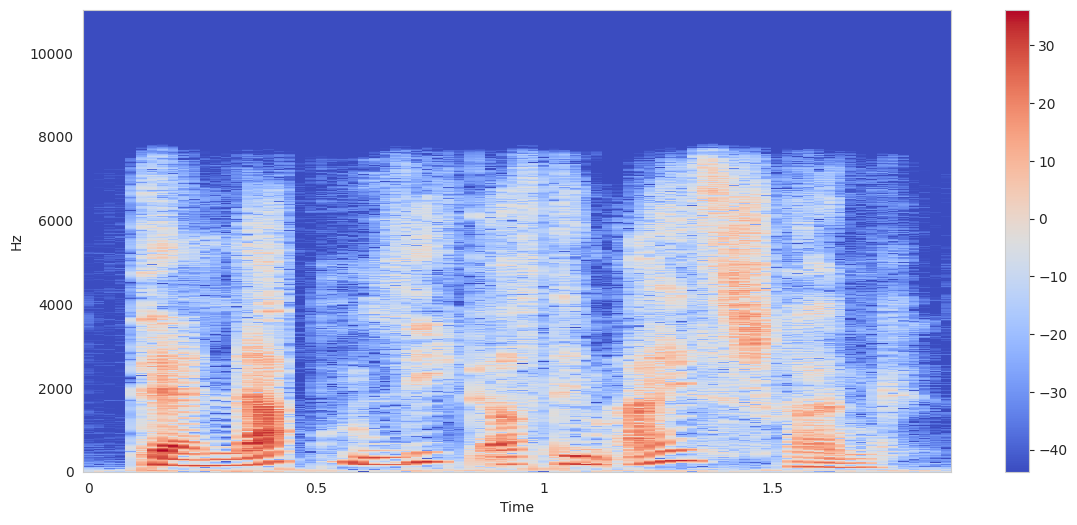

In [6]:
stft = librosa.stft(audio_data)
stft_db = librosa.amplitude_to_db(abs(stft))

plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sampling_rate, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

#### Zero crossing rate

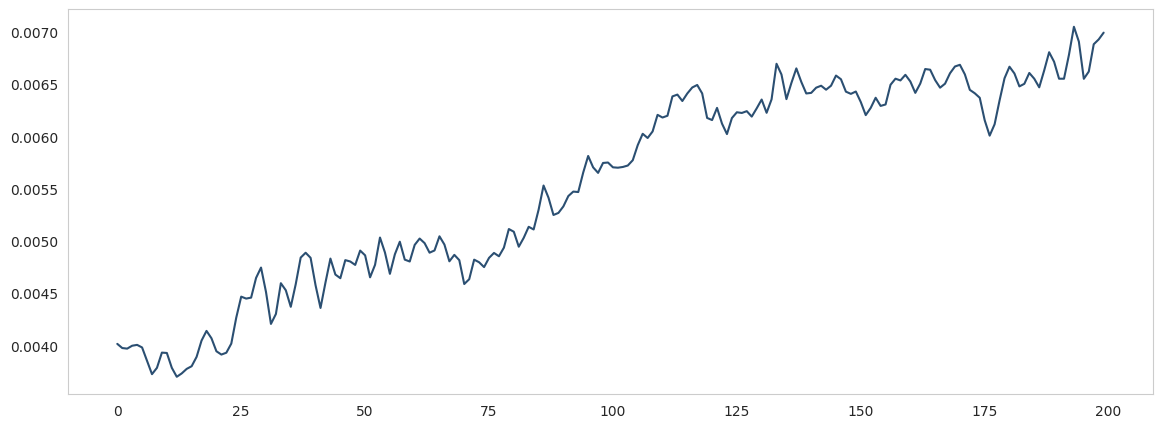

In [9]:
start = 1000
end = 1200
plt.figure(figsize=(14, 5))
plt.plot(audio_data[start:end], color="#2B4F72")
plt.grid()

In [80]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [185]:
def extract_features(data, sample_rate):
    result = np.array([])
    
    zcr = librosa.feature.zero_crossing_rate(y=data).T
    result = np.hstack((result, np.mean(zcr, axis=0)))
    result = np.hstack((result, np.min(zcr, axis=0)))
    result = np.hstack((result, np.max(zcr, axis=0)))
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate).T
    result = np.hstack((result, np.mean(chroma_stft, axis=0)))
    result = np.hstack((result, np.min(chroma_stft, axis=0)))
    result = np.hstack((result, np.max(chroma_stft, axis=0)))

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate).T
    result = np.hstack((result, np.mean(mfcc, axis=0)))
    result = np.hstack((result, np.min(mfcc, axis=0)))
    result = np.hstack((result, np.max(mfcc, axis=0)))

    # Root Mean Square Value
    rms = librosa.feature.rms(y=data).T
    result = np.hstack((result, np.mean(rms, axis=0)))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

In [155]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Without AUGMENTATION
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Data with NOISE
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # Data with STRETCHING and PITCHING
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [186]:
X, y = list(), list()

for i, row in df.iterrows():
    feature = get_features(row.Path)
    if i % 10 == 0:
        print("Import Data: RUNNING ... {} files".format(i))

    for f in feature:
        X.append(f)
        y.append(row.Emotion)
    
print(len(X))
print(len(y))

audio_features = pd.DataFrame(X)
audio_features["labels"] = y

Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 10 files
Import Data: RUNNING ... 20 files
Import Data: RUNNING ... 30 files
Import Data: RUNNING ... 40 files
Import Data: RUNNING ... 50 files
Import Data: RUNNING ... 60 files
Import Data: RUNNING ... 70 files
Import Data: RUNNING ... 80 files
Import Data: RUNNING ... 90 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 110 files
Import Data: RUNNING ... 120 files
Import Data: RUNNING ... 130 files
Import Data: RUNNING ... 140 files
Import Data: RUNNING ... 150 files
Import Data: RUNNING ... 160 files
Import Data: RUNNING ... 170 files
Import Data: RUNNING ... 180 files
Import Data: RUNNING ... 190 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 210 files
Import Data: RUNNING ... 220 files
Import Data: RUNNING ... 230 files
Import Data: RUNNING ... 240 files
Import Data: RUNNING ... 250 files
Import Data: RUNNING ... 260 files
Import Data: RUNNING ... 270 files
Import Data: RUNNING ... 280 fi

In [187]:
audio_features.head()

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,labels
0,0.115618,0.014648,0.465820,0.499997,0.458973,0.467132,0.533155,0.611216,0.681723,0.637542,...,3.539490e-07,3.281293e-07,3.097159e-07,2.959563e-07,2.856786e-07,2.782838e-07,2.728929e-07,2.694104e-07,2.672515e-07,happiness
1,0.254272,0.042969,0.508301,0.628523,0.611465,0.624864,0.680131,0.766794,0.740524,0.678642,...,9.269269e-03,9.721961e-03,1.032883e-02,1.034058e-02,9.622271e-03,9.249572e-03,1.032589e-02,1.092326e-02,1.052640e-02,happiness
2,0.132659,0.016602,0.443359,0.522416,0.489765,0.463516,0.489765,0.582230,0.683922,0.683350,...,2.604799e-07,2.271722e-07,2.047442e-07,1.885915e-07,1.767649e-07,1.685846e-07,1.636956e-07,1.305502e-07,5.106459e-08,happiness
3,0.085127,0.002441,0.362305,0.642731,0.575785,0.654186,0.695828,0.723245,0.746221,0.702634,...,2.302620e-09,2.158167e-09,2.055205e-09,1.977999e-09,1.920291e-09,1.879142e-09,1.849237e-09,1.830345e-09,1.818234e-09,neutral
4,0.277366,0.065430,0.494141,0.765728,0.705725,0.748820,0.818307,0.830257,0.785265,0.724555,...,2.061310e-02,1.927791e-02,1.998155e-02,1.865860e-02,1.865480e-02,2.052270e-02,2.201523e-02,2.146712e-02,2.014943e-02,neutral


In [188]:
X = audio_features.iloc[: ,:-1].values
y = audio_features["labels"].values

encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

print(X.shape)
print(y.shape)

(1605, 228)
(1605, 7)


In [189]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1203, 228)
(1203, 7)
(402, 228)
(402, 7)


### Create base Dense Model

In [190]:
EPOCHS = 250

In [191]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    # tf.keras.layers.Dense(128, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 256)               58624     
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 64)                16448     
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 7)                 455       
                                                                 
Total params: 75,527
Trainable params: 75,527
Non-trainable params: 0
_________________________________________________________________


In [192]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [193]:
checkpoint_filepath = "./checkpoint"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True)

In [194]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS, batch_size=32, callbacks=[model_checkpoint_callback])

Epoch 1/250
26/38 [===================>..........] - ETA: 0s - loss: 33.5060 - accuracy: 0.1743 

2023-08-26 17:32:36.951876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:36.965543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:37.085362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 2s 43ms/step - loss: 25.3592 - accuracy: 0.1870 - val_loss: 1.9187 - val_accuracy: 0.2189
Epoch 2/250
36/38 [===========================>..] - ETA: 0s - loss: 3.3553 - accuracy: 0.2109

2023-08-26 17:32:37.825359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:37.840140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:37.953953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 3.3437 - accuracy: 0.2120 - val_loss: 1.8958 - val_accuracy: 0.2786
Epoch 3/250
36/38 [===========================>..] - ETA: 0s - loss: 2.2448 - accuracy: 0.2543

2023-08-26 17:32:38.649915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:38.661824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:38.775762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 2.2355 - accuracy: 0.2569 - val_loss: 1.8845 - val_accuracy: 0.2811
Epoch 4/250
38/38 [==============================] - 0s 5ms/step - loss: 2.1270 - accuracy: 0.2502 - val_loss: 1.8962 - val_accuracy: 0.2786
Epoch 5/250
23/38 [=================>............] - ETA: 0s - loss: 1.9641 - accuracy: 0.2486

2023-08-26 17:32:39.655288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:39.666490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:39.792285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 1.9662 - accuracy: 0.2527 - val_loss: 1.8850 - val_accuracy: 0.2836
Epoch 6/250
38/38 [==============================] - 0s 3ms/step - loss: 1.9185 - accuracy: 0.2494 - val_loss: 1.8580 - val_accuracy: 0.2811
Epoch 7/250
25/38 [==================>...........] - ETA: 0s - loss: 1.9948 - accuracy: 0.2500

2023-08-26 17:32:40.604788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:40.619499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:40.733612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 1.9487 - accuracy: 0.2594 - val_loss: 1.8627 - val_accuracy: 0.2861
Epoch 8/250
38/38 [==============================] - 0s 4ms/step - loss: 1.9723 - accuracy: 0.2519 - val_loss: 1.8370 - val_accuracy: 0.2836
Epoch 9/250
37/38 [============================>.] - ETA: 0s - loss: 1.9184 - accuracy: 0.2635

2023-08-26 17:32:41.563923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:41.576041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:41.687848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 1.9174 - accuracy: 0.2618 - val_loss: 1.8124 - val_accuracy: 0.2960
Epoch 10/250
38/38 [==============================] - 0s 5ms/step - loss: 1.8687 - accuracy: 0.2519 - val_loss: 1.7576 - val_accuracy: 0.2960
Epoch 11/250
38/38 [==============================] - 0s 3ms/step - loss: 1.9258 - accuracy: 0.2535 - val_loss: 1.8149 - val_accuracy: 0.2935
Epoch 12/250
38/38 [==============================] - 0s 3ms/step - loss: 1.8617 - accuracy: 0.2519 - val_loss: 1.7908 - val_accuracy: 0.2910
Epoch 13/250
38/38 [==============================] - 0s 4ms/step - loss: 1.8221 - accuracy: 0.2510 - val_loss: 1.6867 - val_accuracy: 0.2910
Epoch 14/250
23/38 [=================>............] - ETA: 0s - loss: 1.7774 - accuracy: 0.2459

2023-08-26 17:32:42.968470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:42.980348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:43.126172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 1.7874 - accuracy: 0.2560 - val_loss: 1.6427 - val_accuracy: 0.3109
Epoch 15/250
38/38 [==============================] - 0s 3ms/step - loss: 1.7615 - accuracy: 0.2768 - val_loss: 1.6098 - val_accuracy: 0.2985
Epoch 16/250
27/38 [====================>.........] - ETA: 0s - loss: 1.7254 - accuracy: 0.2824

2023-08-26 17:32:43.930069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:43.948465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:44.062482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 1.7188 - accuracy: 0.2876 - val_loss: 1.5693 - val_accuracy: 0.3184
Epoch 17/250
23/38 [=================>............] - ETA: 0s - loss: 1.6642 - accuracy: 0.3125

2023-08-26 17:32:44.714393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:44.729060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:44.847971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 1.6743 - accuracy: 0.2943 - val_loss: 1.4889 - val_accuracy: 0.3234
Epoch 18/250
38/38 [==============================] - 0s 3ms/step - loss: 1.7309 - accuracy: 0.2801 - val_loss: 1.5598 - val_accuracy: 0.3209
Epoch 19/250
38/38 [==============================] - 0s 4ms/step - loss: 1.6994 - accuracy: 0.2810 - val_loss: 1.4981 - val_accuracy: 0.3109
Epoch 20/250
23/38 [=================>............] - ETA: 0s - loss: 1.6649 - accuracy: 0.3261

2023-08-26 17:32:45.787526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:45.798962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:45.933194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 1.6624 - accuracy: 0.3275 - val_loss: 1.4431 - val_accuracy: 0.4652
Epoch 21/250
38/38 [==============================] - 0s 4ms/step - loss: 1.6678 - accuracy: 0.3308 - val_loss: 1.4206 - val_accuracy: 0.4378
Epoch 22/250
22/38 [================>.............] - ETA: 0s - loss: 1.6663 - accuracy: 0.3622

2023-08-26 17:32:46.746748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:46.761190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:46.899166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 1.6395 - accuracy: 0.3599 - val_loss: 1.3810 - val_accuracy: 0.4801
Epoch 23/250
23/38 [=================>............] - ETA: 0s - loss: 1.5811 - accuracy: 0.3723

2023-08-26 17:32:47.627092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:47.638486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:48.072804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 31ms/step - loss: 1.5842 - accuracy: 0.3741 - val_loss: 1.3641 - val_accuracy: 0.4900
Epoch 24/250
38/38 [==============================] - 0s 3ms/step - loss: 1.5417 - accuracy: 0.3824 - val_loss: 1.2815 - val_accuracy: 0.4677
Epoch 25/250
24/38 [=================>............] - ETA: 0s - loss: 1.5697 - accuracy: 0.3594

2023-08-26 17:32:48.938310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:48.951275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:49.069194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 1.5557 - accuracy: 0.3633 - val_loss: 1.3417 - val_accuracy: 0.4950
Epoch 26/250
37/38 [============================>.] - ETA: 0s - loss: 1.5145 - accuracy: 0.3792

2023-08-26 17:32:49.770519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:49.782797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:49.900833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 1.5231 - accuracy: 0.3782 - val_loss: 1.2440 - val_accuracy: 0.5124
Epoch 27/250
38/38 [==============================] - 0s 4ms/step - loss: 1.4887 - accuracy: 0.4098 - val_loss: 1.2429 - val_accuracy: 0.4900
Epoch 28/250
38/38 [==============================] - 0s 3ms/step - loss: 1.4468 - accuracy: 0.3807 - val_loss: 1.2090 - val_accuracy: 0.5025
Epoch 29/250
38/38 [==============================] - 0s 3ms/step - loss: 1.4498 - accuracy: 0.3907 - val_loss: 1.1876 - val_accuracy: 0.4826
Epoch 30/250
38/38 [==============================] - 0s 5ms/step - loss: 1.4047 - accuracy: 0.4173 - val_loss: 1.1883 - val_accuracy: 0.5050
Epoch 31/250
22/38 [================>.............] - ETA: 0s - loss: 1.3748 - accuracy: 0.4134

2023-08-26 17:32:51.143877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:51.155278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:51.288306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 1.3993 - accuracy: 0.3940 - val_loss: 1.1661 - val_accuracy: 0.5274
Epoch 32/250
38/38 [==============================] - 0s 4ms/step - loss: 1.4279 - accuracy: 0.3973 - val_loss: 1.1206 - val_accuracy: 0.5199
Epoch 33/250
38/38 [==============================] - 0s 3ms/step - loss: 1.3870 - accuracy: 0.4198 - val_loss: 1.1113 - val_accuracy: 0.5075
Epoch 34/250
38/38 [==============================] - 0s 4ms/step - loss: 1.3992 - accuracy: 0.4298 - val_loss: 1.1136 - val_accuracy: 0.5249
Epoch 35/250
26/38 [===================>..........] - ETA: 0s - loss: 1.3626 - accuracy: 0.4303

2023-08-26 17:32:52.335262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:52.346738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:52.487842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 1.3651 - accuracy: 0.4248 - val_loss: 1.1050 - val_accuracy: 0.5299
Epoch 36/250
21/38 [===============>..............] - ETA: 0s - loss: 1.3827 - accuracy: 0.4182

2023-08-26 17:32:53.148284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:53.163267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:53.295463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 1.3826 - accuracy: 0.4198 - val_loss: 1.0865 - val_accuracy: 0.5448
Epoch 37/250
21/38 [===============>..............] - ETA: 0s - loss: 1.3154 - accuracy: 0.4226

2023-08-26 17:32:53.949153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:53.968600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:54.136876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 1.3250 - accuracy: 0.4431 - val_loss: 1.0615 - val_accuracy: 0.5547
Epoch 38/250
21/38 [===============>..............] - ETA: 0s - loss: 1.3426 - accuracy: 0.4524

2023-08-26 17:32:54.795916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:54.811107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:54.949567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 1.3230 - accuracy: 0.4605 - val_loss: 1.0372 - val_accuracy: 0.5721
Epoch 39/250
38/38 [==============================] - 0s 3ms/step - loss: 1.2847 - accuracy: 0.4514 - val_loss: 1.0196 - val_accuracy: 0.5473
Epoch 40/250
25/38 [==================>...........] - ETA: 0s - loss: 1.2859 - accuracy: 0.4425

2023-08-26 17:32:55.768541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:55.779909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:55.893138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 1.2688 - accuracy: 0.4431 - val_loss: 1.0187 - val_accuracy: 0.5771
Epoch 41/250
36/38 [===========================>..] - ETA: 0s - loss: 1.2540 - accuracy: 0.4583

2023-08-26 17:32:56.613843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:56.625594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:56.738627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 1.2558 - accuracy: 0.4580 - val_loss: 0.9962 - val_accuracy: 0.5821
Epoch 42/250
37/38 [============================>.] - ETA: 0s - loss: 1.2826 - accuracy: 0.4637

2023-08-26 17:32:57.499484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:57.511461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:57.625203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 1.2845 - accuracy: 0.4655 - val_loss: 1.0016 - val_accuracy: 0.5846
Epoch 43/250
38/38 [==============================] - 0s 5ms/step - loss: 1.2375 - accuracy: 0.4722 - val_loss: 1.0010 - val_accuracy: 0.5821
Epoch 44/250
38/38 [==============================] - 0s 3ms/step - loss: 1.2160 - accuracy: 0.5046 - val_loss: 0.9791 - val_accuracy: 0.5771
Epoch 45/250
25/38 [==================>...........] - ETA: 0s - loss: 1.2052 - accuracy: 0.4812

2023-08-26 17:32:58.654607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:58.666250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:58.776376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 31ms/step - loss: 1.2178 - accuracy: 0.4796 - val_loss: 0.9664 - val_accuracy: 0.6020
Epoch 46/250
23/38 [=================>............] - ETA: 0s - loss: 1.2169 - accuracy: 0.4755

2023-08-26 17:32:59.811089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:59.822778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:32:59.943954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:32:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 24ms/step - loss: 1.2333 - accuracy: 0.4780 - val_loss: 0.9696 - val_accuracy: 0.6045
Epoch 47/250
25/38 [==================>...........] - ETA: 0s - loss: 1.1713 - accuracy: 0.4988

2023-08-26 17:33:00.706613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:00.718537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:00.829464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 1.1816 - accuracy: 0.5046 - val_loss: 0.9352 - val_accuracy: 0.6169
Epoch 48/250
38/38 [==============================] - 0s 4ms/step - loss: 1.1964 - accuracy: 0.4963 - val_loss: 0.9589 - val_accuracy: 0.5920
Epoch 49/250
38/38 [==============================] - 0s 3ms/step - loss: 1.1454 - accuracy: 0.5087 - val_loss: 0.9146 - val_accuracy: 0.6020
Epoch 50/250
38/38 [==============================] - 0s 3ms/step - loss: 1.1490 - accuracy: 0.5212 - val_loss: 0.9231 - val_accuracy: 0.6119
Epoch 51/250
38/38 [==============================] - 0s 4ms/step - loss: 1.1159 - accuracy: 0.5370 - val_loss: 0.9220 - val_accuracy: 0.5970
Epoch 52/250
38/38 [==============================] - 0s 3ms/step - loss: 1.1694 - accuracy: 0.5453 - val_loss: 0.9096 - val_accuracy: 0.6169
Epoch 53/250
38/38 [==============================] - 0s 3ms/step - loss: 1.1684 - accuracy: 0.5145 - val_loss: 0.9293 - val_accuracy: 0.5896
Epoch 54/250
26/38

2023-08-26 17:33:02.334354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:02.345983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:02.461998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 1.0912 - accuracy: 0.5195 - val_loss: 0.8997 - val_accuracy: 0.6517
Epoch 55/250
38/38 [==============================] - 0s 5ms/step - loss: 1.0641 - accuracy: 0.5486 - val_loss: 0.8837 - val_accuracy: 0.6294
Epoch 56/250
38/38 [==============================] - 0s 3ms/step - loss: 1.0712 - accuracy: 0.5453 - val_loss: 0.8633 - val_accuracy: 0.6468
Epoch 57/250
26/38 [===================>..........] - ETA: 0s - loss: 1.0567 - accuracy: 0.5349

2023-08-26 17:33:03.487889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:03.499295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:03.613983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 1.0479 - accuracy: 0.5486 - val_loss: 0.8194 - val_accuracy: 0.6617
Epoch 58/250
38/38 [==============================] - 0s 4ms/step - loss: 1.0612 - accuracy: 0.5486 - val_loss: 0.8613 - val_accuracy: 0.6592
Epoch 59/250
35/38 [==========================>...] - ETA: 0s - loss: 0.9813 - accuracy: 0.5946

2023-08-26 17:33:04.464065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:04.475488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:04.592632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.9819 - accuracy: 0.5935 - val_loss: 0.8446 - val_accuracy: 0.6741
Epoch 60/250
38/38 [==============================] - 0s 5ms/step - loss: 1.0581 - accuracy: 0.5644 - val_loss: 0.8506 - val_accuracy: 0.6567
Epoch 61/250
38/38 [==============================] - 0s 3ms/step - loss: 1.0275 - accuracy: 0.5661 - val_loss: 0.8783 - val_accuracy: 0.6219
Epoch 62/250
38/38 [==============================] - 0s 3ms/step - loss: 1.0346 - accuracy: 0.5653 - val_loss: 0.8178 - val_accuracy: 0.6716
Epoch 63/250
31/38 [=======================>......] - ETA: 0s - loss: 0.9874 - accuracy: 0.5857

2023-08-26 17:33:05.722987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:05.735465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:05.844164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 0.9868 - accuracy: 0.5852 - val_loss: 0.8213 - val_accuracy: 0.6766
Epoch 64/250
32/38 [========================>.....] - ETA: 0s - loss: 0.9901 - accuracy: 0.5791

2023-08-26 17:33:06.622637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:06.636374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:06.818236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 26ms/step - loss: 0.9829 - accuracy: 0.5827 - val_loss: 0.8066 - val_accuracy: 0.6841
Epoch 65/250
20/38 [==============>...............] - ETA: 0s - loss: 0.9858 - accuracy: 0.6000

2023-08-26 17:33:07.523878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:07.537115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:07.695772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 0.9742 - accuracy: 0.5927 - val_loss: 0.7750 - val_accuracy: 0.6940
Epoch 66/250
38/38 [==============================] - 0s 3ms/step - loss: 0.9335 - accuracy: 0.6093 - val_loss: 0.7957 - val_accuracy: 0.6940
Epoch 67/250
25/38 [==================>...........] - ETA: 0s - loss: 0.9080 - accuracy: 0.6175

2023-08-26 17:33:08.526140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:08.540460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:08.655734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 0.9314 - accuracy: 0.6068 - val_loss: 0.8090 - val_accuracy: 0.7164
Epoch 68/250
38/38 [==============================] - 0s 4ms/step - loss: 0.9244 - accuracy: 0.6168 - val_loss: 0.7861 - val_accuracy: 0.7065
Epoch 69/250
38/38 [==============================] - 0s 4ms/step - loss: 0.9576 - accuracy: 0.5927 - val_loss: 0.8031 - val_accuracy: 0.6841
Epoch 70/250
38/38 [==============================] - 0s 3ms/step - loss: 0.8684 - accuracy: 0.6318 - val_loss: 0.8109 - val_accuracy: 0.7065
Epoch 71/250
38/38 [==============================] - 0s 3ms/step - loss: 0.9332 - accuracy: 0.6168 - val_loss: 0.7572 - val_accuracy: 0.6965
Epoch 72/250
38/38 [==============================] - 0s 4ms/step - loss: 0.9281 - accuracy: 0.6093 - val_loss: 0.7843 - val_accuracy: 0.6990
Epoch 73/250
38/38 [==============================] - 0s 3ms/step - loss: 0.9017 - accuracy: 0.6160 - val_loss: 0.7756 - val_accuracy: 0.7040
Epoch 74/250
38/38

2023-08-26 17:33:10.400612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:10.411853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:10.567350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.8377 - accuracy: 0.6475 - val_loss: 0.7448 - val_accuracy: 0.7189
Epoch 77/250
38/38 [==============================] - 0s 4ms/step - loss: 0.8324 - accuracy: 0.6467 - val_loss: 0.7113 - val_accuracy: 0.7189
Epoch 78/250
38/38 [==============================] - 0s 3ms/step - loss: 0.8409 - accuracy: 0.6351 - val_loss: 0.7988 - val_accuracy: 0.6791
Epoch 79/250
27/38 [====================>.........] - ETA: 0s - loss: 0.8830 - accuracy: 0.6146

2023-08-26 17:33:11.535654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:11.547310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:11.657677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.8921 - accuracy: 0.6185 - val_loss: 0.7575 - val_accuracy: 0.7338
Epoch 80/250
38/38 [==============================] - 0s 4ms/step - loss: 0.8757 - accuracy: 0.6401 - val_loss: 0.7235 - val_accuracy: 0.7338
Epoch 81/250
38/38 [==============================] - 0s 3ms/step - loss: 0.8342 - accuracy: 0.6451 - val_loss: 0.7511 - val_accuracy: 0.6841
Epoch 82/250
38/38 [==============================] - 0s 3ms/step - loss: 0.8447 - accuracy: 0.6584 - val_loss: 0.7240 - val_accuracy: 0.6940
Epoch 83/250
38/38 [==============================] - 0s 4ms/step - loss: 0.8120 - accuracy: 0.6475 - val_loss: 0.7076 - val_accuracy: 0.7264
Epoch 84/250
20/38 [==============>...............] - ETA: 0s - loss: 0.7627 - accuracy: 0.7031

2023-08-26 17:33:13.208143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:13.219538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:13.334918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 31ms/step - loss: 0.7953 - accuracy: 0.6916 - val_loss: 0.6734 - val_accuracy: 0.7562
Epoch 85/250
38/38 [==============================] - 0s 4ms/step - loss: 0.7908 - accuracy: 0.6825 - val_loss: 0.7019 - val_accuracy: 0.7239
Epoch 86/250
38/38 [==============================] - 0s 3ms/step - loss: 0.8041 - accuracy: 0.6584 - val_loss: 0.7064 - val_accuracy: 0.7537
Epoch 87/250
38/38 [==============================] - 0s 3ms/step - loss: 0.7759 - accuracy: 0.6866 - val_loss: 0.6914 - val_accuracy: 0.7512
Epoch 88/250
38/38 [==============================] - 0s 4ms/step - loss: 0.7584 - accuracy: 0.6766 - val_loss: 0.6917 - val_accuracy: 0.7537
Epoch 89/250
38/38 [==============================] - 0s 3ms/step - loss: 0.7412 - accuracy: 0.6933 - val_loss: 0.6543 - val_accuracy: 0.7562
Epoch 90/250
24/38 [=================>............] - ETA: 0s - loss: 0.7937 - accuracy: 0.6693

2023-08-26 17:33:14.811473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:14.825633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:14.936498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 0.7846 - accuracy: 0.6766 - val_loss: 0.6458 - val_accuracy: 0.7786
Epoch 91/250
38/38 [==============================] - 0s 5ms/step - loss: 0.7333 - accuracy: 0.6933 - val_loss: 0.6946 - val_accuracy: 0.7313
Epoch 92/250
38/38 [==============================] - 0s 3ms/step - loss: 0.7553 - accuracy: 0.6883 - val_loss: 0.6628 - val_accuracy: 0.7562
Epoch 93/250
38/38 [==============================] - 0s 3ms/step - loss: 0.7288 - accuracy: 0.7124 - val_loss: 0.6642 - val_accuracy: 0.7736
Epoch 94/250
23/38 [=================>............] - ETA: 0s - loss: 0.7249 - accuracy: 0.7174

2023-08-26 17:33:16.129228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:16.141082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:16.254037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 24ms/step - loss: 0.7525 - accuracy: 0.7082 - val_loss: 0.6599 - val_accuracy: 0.7811
Epoch 95/250
38/38 [==============================] - 0s 4ms/step - loss: 0.7191 - accuracy: 0.7140 - val_loss: 0.6457 - val_accuracy: 0.7587
Epoch 96/250
25/38 [==================>...........] - ETA: 0s - loss: 0.6762 - accuracy: 0.7450

2023-08-26 17:33:17.111223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:17.126261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:17.255902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 0.7030 - accuracy: 0.7282 - val_loss: 0.6482 - val_accuracy: 0.7861
Epoch 97/250
38/38 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.7182 - val_loss: 0.6567 - val_accuracy: 0.7562
Epoch 98/250
38/38 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.7290 - val_loss: 0.6803 - val_accuracy: 0.7239
Epoch 99/250
38/38 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.7149 - val_loss: 0.6289 - val_accuracy: 0.7562
Epoch 100/250
38/38 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.7340 - val_loss: 0.6635 - val_accuracy: 0.7687
Epoch 101/250
38/38 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.7290 - val_loss: 0.6192 - val_accuracy: 0.7687
Epoch 102/250
38/38 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.7506 - val_loss: 0.6252 - val_accuracy: 0.7662
Epoch 103/250
3

2023-08-26 17:33:19.008763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:19.023291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:19.138429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.6233 - accuracy: 0.7531 - val_loss: 0.6377 - val_accuracy: 0.7960
Epoch 106/250
38/38 [==============================] - 0s 4ms/step - loss: 0.6395 - accuracy: 0.7473 - val_loss: 0.6248 - val_accuracy: 0.7761
Epoch 107/250
38/38 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.7606 - val_loss: 0.5691 - val_accuracy: 0.7811
Epoch 108/250
38/38 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.7473 - val_loss: 0.5945 - val_accuracy: 0.7711
Epoch 109/250
38/38 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.7481 - val_loss: 0.5858 - val_accuracy: 0.7861
Epoch 110/250
38/38 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.7714 - val_loss: 0.6191 - val_accuracy: 0.7836
Epoch 111/250
38/38 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.7689 - val_loss: 0.6350 - val_accuracy: 0.7736
Epoch 112/25

2023-08-26 17:33:20.688756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:20.700191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:20.811132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 0.5986 - accuracy: 0.7714 - val_loss: 0.5649 - val_accuracy: 0.8060
Epoch 113/250
38/38 [==============================] - 0s 4ms/step - loss: 0.5918 - accuracy: 0.7789 - val_loss: 0.5975 - val_accuracy: 0.7761
Epoch 114/250
38/38 [==============================] - 0s 3ms/step - loss: 0.6026 - accuracy: 0.7664 - val_loss: 0.5765 - val_accuracy: 0.7935
Epoch 115/250
38/38 [==============================] - 0s 4ms/step - loss: 0.5694 - accuracy: 0.7714 - val_loss: 0.5723 - val_accuracy: 0.7910
Epoch 116/250
38/38 [==============================] - 0s 4ms/step - loss: 0.5823 - accuracy: 0.7805 - val_loss: 0.6025 - val_accuracy: 0.7687
Epoch 117/250
38/38 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.7797 - val_loss: 0.5465 - val_accuracy: 0.7960
Epoch 118/250
26/38 [===================>..........] - ETA: 0s - loss: 0.5140 - accuracy: 0.8065

2023-08-26 17:33:22.213482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:22.228706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:22.343241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 0.5006 - accuracy: 0.8105 - val_loss: 0.5755 - val_accuracy: 0.8159
Epoch 119/250
38/38 [==============================] - 0s 3ms/step - loss: 0.5363 - accuracy: 0.7930 - val_loss: 0.5760 - val_accuracy: 0.7935
Epoch 120/250
38/38 [==============================] - 0s 5ms/step - loss: 0.5398 - accuracy: 0.7947 - val_loss: 0.5690 - val_accuracy: 0.7985
Epoch 121/250
38/38 [==============================] - 0s 4ms/step - loss: 0.5267 - accuracy: 0.7880 - val_loss: 0.5748 - val_accuracy: 0.7935
Epoch 122/250
38/38 [==============================] - 0s 3ms/step - loss: 0.5271 - accuracy: 0.7972 - val_loss: 0.5382 - val_accuracy: 0.7985
Epoch 123/250
38/38 [==============================] - 0s 4ms/step - loss: 0.5042 - accuracy: 0.7997 - val_loss: 0.5929 - val_accuracy: 0.7935
Epoch 124/250
38/38 [==============================] - 0s 3ms/step - loss: 0.5738 - accuracy: 0.7847 - val_loss: 0.6202 - val_accuracy: 0.8035
Epoch 125/25

2023-08-26 17:33:23.805371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:23.821491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:23.937111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 0.5409 - accuracy: 0.7930 - val_loss: 0.5335 - val_accuracy: 0.8209
Epoch 126/250
38/38 [==============================] - 0s 3ms/step - loss: 0.4939 - accuracy: 0.8180 - val_loss: 0.5677 - val_accuracy: 0.8209
Epoch 127/250
38/38 [==============================] - 0s 4ms/step - loss: 0.5068 - accuracy: 0.8080 - val_loss: 0.5860 - val_accuracy: 0.7935
Epoch 128/250
38/38 [==============================] - 0s 3ms/step - loss: 0.4607 - accuracy: 0.8155 - val_loss: 0.6214 - val_accuracy: 0.7910
Epoch 129/250
38/38 [==============================] - 0s 3ms/step - loss: 0.4826 - accuracy: 0.8204 - val_loss: 0.6457 - val_accuracy: 0.8035
Epoch 130/250
38/38 [==============================] - 0s 5ms/step - loss: 0.4657 - accuracy: 0.8354 - val_loss: 0.6107 - val_accuracy: 0.7960
Epoch 131/250
38/38 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.8088 - val_loss: 0.5816 - val_accuracy: 0.7935
Epoch 132/25

2023-08-26 17:33:26.840493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:26.851363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:26.961070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.4032 - accuracy: 0.8570 - val_loss: 0.5546 - val_accuracy: 0.8333
Epoch 143/250
38/38 [==============================] - 0s 4ms/step - loss: 0.4349 - accuracy: 0.8429 - val_loss: 0.5955 - val_accuracy: 0.7811
Epoch 144/250
38/38 [==============================] - 0s 4ms/step - loss: 0.4438 - accuracy: 0.8313 - val_loss: 0.6200 - val_accuracy: 0.8085
Epoch 145/250
38/38 [==============================] - 0s 3ms/step - loss: 0.4583 - accuracy: 0.8346 - val_loss: 0.5393 - val_accuracy: 0.8333
Epoch 146/250
38/38 [==============================] - 0s 5ms/step - loss: 0.3996 - accuracy: 0.8520 - val_loss: 0.5671 - val_accuracy: 0.8284
Epoch 147/250
38/38 [==============================] - 0s 4ms/step - loss: 0.3852 - accuracy: 0.8446 - val_loss: 0.5979 - val_accuracy: 0.8259
Epoch 148/250
23/38 [=================>............] - ETA: 0s - loss: 0.4559 - accuracy: 0.8356

2023-08-26 17:33:28.400154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:28.412625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:28.528113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 0.4568 - accuracy: 0.8329 - val_loss: 0.4693 - val_accuracy: 0.8408
Epoch 149/250
38/38 [==============================] - 0s 4ms/step - loss: 0.4134 - accuracy: 0.8487 - val_loss: 0.5987 - val_accuracy: 0.8159
Epoch 150/250
36/38 [===========================>..] - ETA: 0s - loss: 0.4229 - accuracy: 0.8481

2023-08-26 17:33:29.356217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:29.369441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:29.476854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 29ms/step - loss: 0.4209 - accuracy: 0.8487 - val_loss: 0.4914 - val_accuracy: 0.8458
Epoch 151/250
38/38 [==============================] - 0s 3ms/step - loss: 0.4315 - accuracy: 0.8379 - val_loss: 0.6239 - val_accuracy: 0.7985
Epoch 152/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3745 - accuracy: 0.8653 - val_loss: 0.5876 - val_accuracy: 0.8209
Epoch 153/250
38/38 [==============================] - 0s 4ms/step - loss: 0.4151 - accuracy: 0.8479 - val_loss: 0.5834 - val_accuracy: 0.8308
Epoch 154/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3655 - accuracy: 0.8712 - val_loss: 0.5898 - val_accuracy: 0.8358
Epoch 155/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3651 - accuracy: 0.8612 - val_loss: 0.5842 - val_accuracy: 0.8408
Epoch 156/250
38/38 [==============================] - 0s 4ms/step - loss: 0.3887 - accuracy: 0.8462 - val_loss: 0.5624 - val_accuracy: 0.8209
Epoch 157/25

2023-08-26 17:33:35.327667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:35.342769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:35.474385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 0.3259 - accuracy: 0.8845 - val_loss: 0.5469 - val_accuracy: 0.8483
Epoch 187/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3241 - accuracy: 0.8753 - val_loss: 0.5927 - val_accuracy: 0.8433
Epoch 188/250
38/38 [==============================] - 0s 4ms/step - loss: 0.3351 - accuracy: 0.8712 - val_loss: 0.5886 - val_accuracy: 0.8383
Epoch 189/250
38/38 [==============================] - 0s 4ms/step - loss: 0.3560 - accuracy: 0.8761 - val_loss: 0.6967 - val_accuracy: 0.8159
Epoch 190/250
26/38 [===================>..........] - ETA: 0s - loss: 0.3632 - accuracy: 0.8726

2023-08-26 17:33:36.555391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:36.573891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:36.747036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 0.3486 - accuracy: 0.8803 - val_loss: 0.5302 - val_accuracy: 0.8532
Epoch 191/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8886 - val_loss: 0.6325 - val_accuracy: 0.8433
Epoch 192/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3184 - accuracy: 0.8903 - val_loss: 0.5941 - val_accuracy: 0.8358
Epoch 193/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2771 - accuracy: 0.8961 - val_loss: 0.6061 - val_accuracy: 0.8458
Epoch 194/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3103 - accuracy: 0.8869 - val_loss: 0.6410 - val_accuracy: 0.8458
Epoch 195/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2727 - accuracy: 0.8969 - val_loss: 0.6218 - val_accuracy: 0.8532
Epoch 196/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2735 - accuracy: 0.8994 - val_loss: 0.6351 - val_accuracy: 0.8358
Epoch 197/25

2023-08-26 17:33:38.437849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:38.448796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:38.557873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.3168 - accuracy: 0.8953 - val_loss: 0.5479 - val_accuracy: 0.8657
Epoch 199/250
38/38 [==============================] - 0s 5ms/step - loss: 0.3033 - accuracy: 0.8986 - val_loss: 0.6916 - val_accuracy: 0.8333
Epoch 200/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2819 - accuracy: 0.8986 - val_loss: 0.6836 - val_accuracy: 0.8458
Epoch 201/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2651 - accuracy: 0.8994 - val_loss: 0.7005 - val_accuracy: 0.8532
Epoch 202/250
38/38 [==============================] - 0s 4ms/step - loss: 0.3547 - accuracy: 0.8703 - val_loss: 0.5674 - val_accuracy: 0.8507
Epoch 203/250
38/38 [==============================] - 0s 3ms/step - loss: 0.3188 - accuracy: 0.8795 - val_loss: 0.6989 - val_accuracy: 0.8383
Epoch 204/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2984 - accuracy: 0.8919 - val_loss: 0.6524 - val_accuracy: 0.8582
Epoch 205/25

2023-08-26 17:33:41.838991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:41.850515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:41.959870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.2330 - accuracy: 0.9169 - val_loss: 0.6544 - val_accuracy: 0.8682
Epoch 220/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2709 - accuracy: 0.9027 - val_loss: 0.6708 - val_accuracy: 0.8483
Epoch 221/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2528 - accuracy: 0.9135 - val_loss: 0.6660 - val_accuracy: 0.8483
Epoch 222/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2747 - accuracy: 0.8978 - val_loss: 0.6313 - val_accuracy: 0.8358
Epoch 223/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2949 - accuracy: 0.9002 - val_loss: 0.6505 - val_accuracy: 0.8458
Epoch 224/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.8886 - val_loss: 0.6634 - val_accuracy: 0.8433
Epoch 225/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.9152 - val_loss: 0.5911 - val_accuracy: 0.8557
Epoch 226/25

2023-08-26 17:33:43.770304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:43.781579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:43.891192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 23ms/step - loss: 0.3080 - accuracy: 0.9044 - val_loss: 0.6349 - val_accuracy: 0.8706
Epoch 229/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2727 - accuracy: 0.9169 - val_loss: 0.6955 - val_accuracy: 0.8607
Epoch 230/250
21/38 [===============>..............] - ETA: 0s - loss: 0.2053 - accuracy: 0.9226

2023-08-26 17:33:44.734158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:44.746127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:44.856327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 21ms/step - loss: 0.2279 - accuracy: 0.9219 - val_loss: 0.6350 - val_accuracy: 0.8731
Epoch 231/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2457 - accuracy: 0.9127 - val_loss: 0.6818 - val_accuracy: 0.8582
Epoch 232/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2664 - accuracy: 0.9052 - val_loss: 0.6063 - val_accuracy: 0.8632
Epoch 233/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2214 - accuracy: 0.9285 - val_loss: 0.6775 - val_accuracy: 0.8657
Epoch 234/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2411 - accuracy: 0.9169 - val_loss: 0.6454 - val_accuracy: 0.8433
Epoch 235/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2663 - accuracy: 0.9019 - val_loss: 0.6327 - val_accuracy: 0.8607
Epoch 236/250
38/38 [==============================] - 0s 3ms/step - loss: 0.1878 - accuracy: 0.9327 - val_loss: 0.6497 - val_accuracy: 0.8582
Epoch 237/25

2023-08-26 17:33:46.458627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:46.469828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-08-26 17:33:46.618997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-08-26 17:33:

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


38/38 [==============================] - 1s 22ms/step - loss: 0.2082 - accuracy: 0.9185 - val_loss: 0.6255 - val_accuracy: 0.8781
Epoch 239/250
38/38 [==============================] - 0s 4ms/step - loss: 0.1985 - accuracy: 0.9244 - val_loss: 0.6862 - val_accuracy: 0.8607
Epoch 240/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2538 - accuracy: 0.9061 - val_loss: 0.6290 - val_accuracy: 0.8582
Epoch 241/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2746 - accuracy: 0.9052 - val_loss: 0.6091 - val_accuracy: 0.8682
Epoch 242/250
38/38 [==============================] - 0s 4ms/step - loss: 0.2061 - accuracy: 0.9335 - val_loss: 0.6476 - val_accuracy: 0.8582
Epoch 243/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 0.9227 - val_loss: 0.5552 - val_accuracy: 0.8706
Epoch 244/250
38/38 [==============================] - 0s 3ms/step - loss: 0.2698 - accuracy: 0.9119 - val_loss: 0.6392 - val_accuracy: 0.8607
Epoch 245/25

### Create Branched CNN Model

In [198]:
branched_cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(x_train.shape[1],1)),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    # Branch 1
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=128,kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling1D(2),
    # Branch 2
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation="softmax")
])

In [199]:
branched_cnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 228, 16)           64        
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 114, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 114, 32)           1568      
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 57, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 57, 64)            6208      
                                                                 
 batch_normalization_20 (Bat  (None, 57, 64)         

In [201]:
branched_cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-6, momentum=0.8), loss="categorical_crossentropy", metrics= ["accuracy"])

In [202]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history_branched_cnn = branched_cnn_model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), callbacks=[reduce_on_plateau])

Epoch 1/100
10/10 [==============================] - 3s 90ms/step - loss: 2.1246 - accuracy: 0.2236 - val_loss: 1.8011 - val_accuracy: 0.2886 - lr: 0.0100
Epoch 2/100
10/10 [==============================] - 1s 76ms/step - loss: 1.6481 - accuracy: 0.3699 - val_loss: 1.8078 - val_accuracy: 0.2413 - lr: 0.0100
Epoch 3/100
10/10 [==============================] - 1s 98ms/step - loss: 1.4428 - accuracy: 0.4156 - val_loss: 1.5354 - val_accuracy: 0.3308 - lr: 0.0100
Epoch 4/100
10/10 [==============================] - 1s 87ms/step - loss: 1.4066 - accuracy: 0.4364 - val_loss: 1.7626 - val_accuracy: 0.2114 - lr: 0.0100
Epoch 5/100
10/10 [==============================] - 1s 76ms/step - loss: 1.2844 - accuracy: 0.4913 - val_loss: 1.6763 - val_accuracy: 0.2761 - lr: 0.0100
Epoch 6/100
10/10 [==============================] - 2s 164ms/step - loss: 1.2621 - accuracy: 0.4722 - val_loss: 1.4501 - val_accuracy: 0.4279 - lr: 0.0100
Epoch 7/100
10/10 [==============================] - 1s 69ms/step - l

### Eval helper Methods

In [42]:
def print_history(trained_model, history_data, epochs):
    print(f"Accuracy of the model on test data : {trained_model.evaluate(x_test, y_test)[1] * 100} %")

    epochs = [i for i in range(epochs)]
    
    fig , ax = plt.subplots(1, 2)
    train_acc = history_data.history["accuracy"]
    train_loss = history_data.history["loss"]
    test_acc = history_data.history["val_accuracy"]
    test_loss = history_data.history["val_loss"]
    
    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label="Training Loss")
    ax[0].plot(epochs, test_loss , label="Testing Loss")
    ax[0].set_title("Training & Testing Loss")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    
    ax[1].plot(epochs, train_acc, label="Training Accuracy")
    ax[1].plot(epochs, test_acc, label="Testing Accuracy")
    ax[1].set_title("Training & Testing Accuracy")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

In [37]:
def execute_prediction(trained_model):
    pred_test = trained_model.predict(x_test)
    y_pred = encoder.inverse_transform(pred_test)
    y_test_inverse = encoder.inverse_transform(y_test)
    
    df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
    df['Predicted Labels'] = y_pred.flatten()
    df['Actual Labels'] = y_test_inverse.flatten()
    
    print(df.head(10))
    
    cm = confusion_matrix(y_test_inverse, y_pred)
    cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
    
    plt.figure(figsize = (12, 10))
    sns.heatmap(cm, annot=True, cmap="Blues",  fmt=".2f")
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()
    
    print(classification_report(y_test_inverse, y_pred))

### Eval base Model

13/13 [==============================] - 0s 2ms/step - loss: 0.6255 - accuracy: 0.8781
Accuracy of the model on test data : 87.81094551086426 %


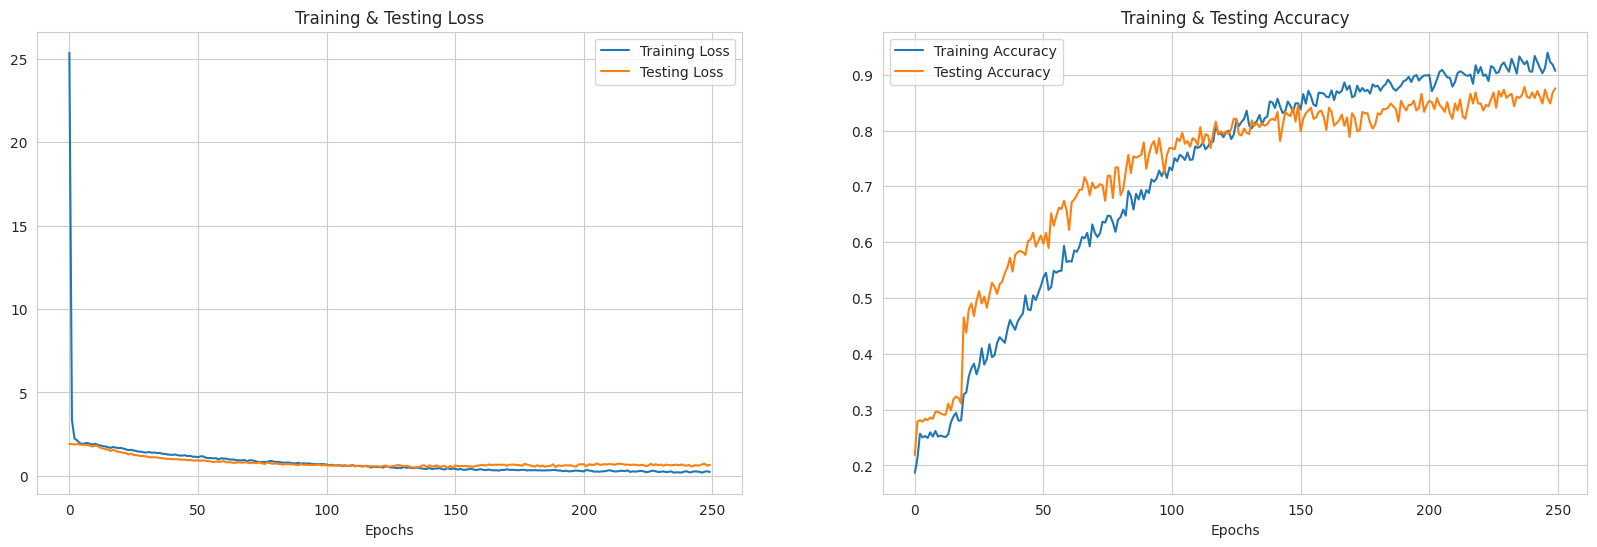

In [195]:
model = tf.keras.models.load_model("./checkpoint")
print_history(model, history, EPOCHS)

13/13 [==============================] - 0s 2ms/step
  Predicted Labels Actual Labels
0          neutral       boredom
1          anxiety       disgust
2          anxiety       anxiety
3          neutral       neutral
4            anger         anger
5          neutral       neutral
6          boredom       boredom
7          disgust     happiness
8            anger         anger
9            anger         anger


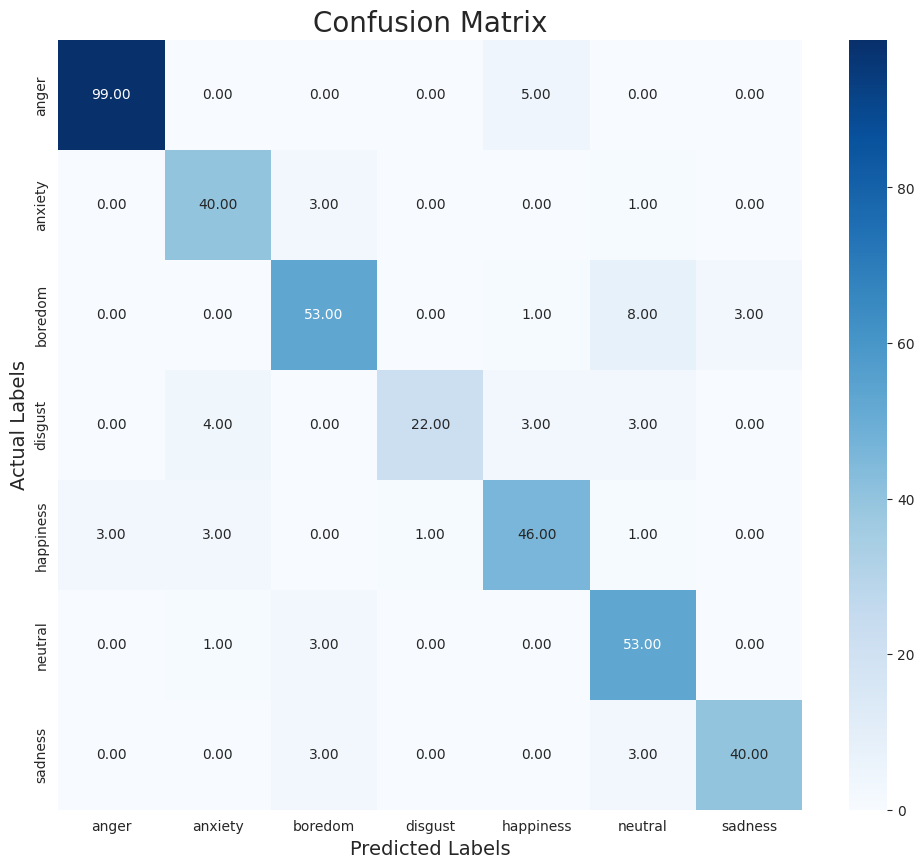

              precision    recall  f1-score   support

       anger       0.97      0.95      0.96       104
     anxiety       0.83      0.91      0.87        44
     boredom       0.85      0.82      0.83        65
     disgust       0.96      0.69      0.80        32
   happiness       0.84      0.85      0.84        54
     neutral       0.77      0.93      0.84        57
     sadness       0.93      0.87      0.90        46

    accuracy                           0.88       402
   macro avg       0.88      0.86      0.86       402
weighted avg       0.88      0.88      0.88       402


In [196]:
execute_prediction(model)

### Eval branched CNN

13/13 [==============================] - 0s 7ms/step - loss: 0.5096 - accuracy: 0.8209
Accuracy of the model on test data : 82.08954930305481 %


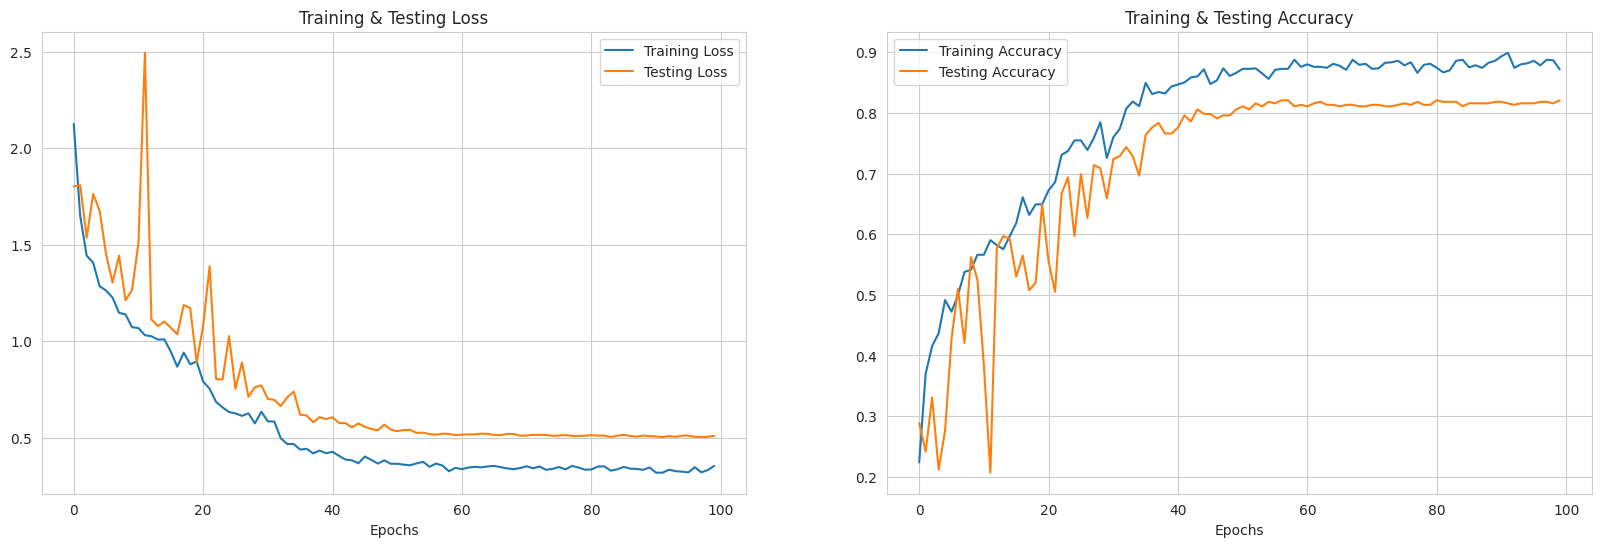

In [203]:
print_history(branched_cnn_model, history_branched_cnn, 100)

13/13 [==============================] - 0s 5ms/step
  Predicted Labels Actual Labels
0          neutral       boredom
1          anxiety       disgust
2          anxiety       anxiety
3          neutral       neutral
4            anger         anger
5          boredom       neutral
6          boredom       boredom
7          disgust     happiness
8            anger         anger
9            anger         anger


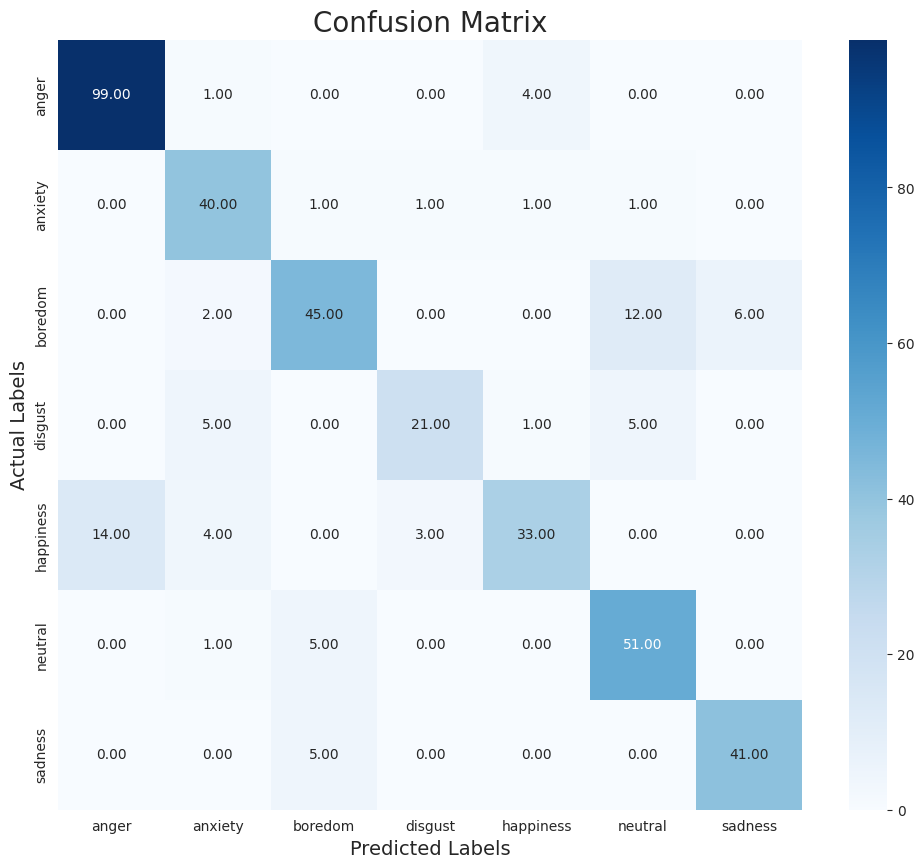

              precision    recall  f1-score   support

       anger       0.88      0.95      0.91       104
     anxiety       0.75      0.91      0.82        44
     boredom       0.80      0.69      0.74        65
     disgust       0.84      0.66      0.74        32
   happiness       0.85      0.61      0.71        54
     neutral       0.74      0.89      0.81        57
     sadness       0.87      0.89      0.88        46

    accuracy                           0.82       402
   macro avg       0.82      0.80      0.80       402
weighted avg       0.82      0.82      0.82       402


In [204]:
execute_prediction(branched_cnn_model)

### Save Model

In [197]:
model.save("./emotion-detection.h5")